# Text Classification with Hugging Face Transformers in ktrain

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
from sklearn.datasets import fetch_20newsgroups
import ktrain
from ktrain import text

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";   

## Load Data Into Arrays


In [7]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']

train_b = fetch_20newsgroups(subset='train', categories=categories, 
                             shuffle=True, random_state=42)

test_b = fetch_20newsgroups(subset='test', categories=categories, 
                            shuffle=True, random_state=42)


print('size of training set: %s' % (len(train_b['data'])))
print('size of validation set: %s' % (len(test_b['data'])))
print('classes: %s' % (train_b.target_names))

x_train = train_b.data
y_train = train_b.target
x_test = test_b.data
y_test = test_b.target

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


## STEP 1: Preprocess Data and Build a Transformer Model

In [11]:
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=train_b.target_names)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=6)

preprocessing train...
language: en
train sequence lengths:
	mean : 308
	95percentile : 837
	99percentile : 1938


preprocessing test...
language: en
test sequence lengths:
	mean : 343
	95percentile : 979
	99percentile : 2562


## STEP 2 [Optional]: Estimate a Good Learning Rate¶

simulating training for different learning rates... this may take a few moments...
Train for 376 steps
Epoch 1/2
376/376 [==============================] - 88s 233ms/step - loss: 1.0806 - accuracy: 0.5151
Epoch 2/2
376/376 [==============================] - 81s 215ms/step - loss: 1.6581 - accuracy: 0.2506


done.
Visually inspect loss plot and select learning rate associated with falling loss


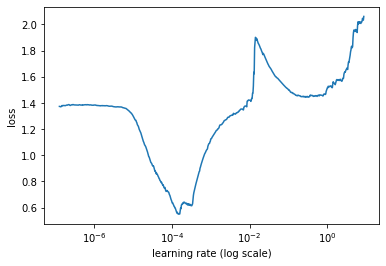

In [12]:
learner.lr_find(show_plot=True, max_epochs=2)

## STEP 3: Train Model

In [13]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Train for 377 steps, validate for 47 steps
Epoch 1/4
377/377 [==============================] - 98s 259ms/step - loss: 0.6471 - accuracy: 0.7669 - val_loss: 0.2137 - val_accuracy: 0.9301
Epoch 2/4
377/377 [==============================] - 96s 255ms/step - loss: 0.1260 - accuracy: 0.9641 - val_loss: 0.1970 - val_accuracy: 0.9401
Epoch 3/4
377/377 [==============================] - 96s 255ms/step - loss: 0.0766 - accuracy: 0.9805 - val_loss: 0.2073 - val_accuracy: 0.9427
Epoch 4/4
377/377 [==============================] - 96s 255ms/step - loss: 0.0234 - accuracy: 0.9942 - val_loss: 0.2023 - val_accuracy: 0.9467


## STEP 4: Evaluate/Inspect Model

In [14]:
learner.validate(class_names=t.get_classes())

                        precision    recall  f1-score   support

           alt.atheism       0.90      0.91      0.90       319
         comp.graphics       0.98      0.93      0.95       389
               sci.med       0.96      0.96      0.96       396
soc.religion.christian       0.94      0.97      0.96       398

              accuracy                           0.95      1502
             macro avg       0.95      0.94      0.94      1502
          weighted avg       0.95      0.95      0.95      1502



array([[290,   1,   8,  20],
       [ 16, 363,   7,   3],
       [  9,   6, 381,   0],
       [  7,   2,   1, 388]])

In [21]:
# the one we got most wrong
learner.view_top_losses(n=3, preproc=t)

----------
id:1393 | loss:7.27 | true:comp.graphics | pred:alt.atheism)

----------
id:146 | loss:7.19 | true:comp.graphics | pred:alt.atheism)

----------
id:1335 | loss:6.97 | true:comp.graphics | pred:alt.atheism)



In [22]:
print(x_test[1393])

From: krsear02@ulkyvx.louisville.edu (Kendall 'Opusii' Sears)
Subject: Re: Where did the hacker ethic go?
Lines: 46
Nntp-Posting-Host: ulkyvx.louisville.edu
Organization: University of Louisville

>Where did the hacker ethic go?
>
>We hackers of the 70's and 80' are now comfortably employed
>and supporting families.  The next generation takes
>the radical lead now.  Don't look for radicalism among us
>old ones; we're gone...

Perhaps all of us hackers have become (ICK) PROFESSIONALS?  I have noticed
my and my associates progression from hackers to computer professionals.
It is rather distasteful.  It occurs when a series of things happen:

   1) one's ego outgrows one's talent/knowledge
   2) one's financial situation takes precedence
   3) A change in priorities (esp. family) possibly leading to 2)
   4) the hacker's attitude makes the shift from "fun" to "work"
   5) one's vocation burns away the creativity needed for "the hobby"

or the biggest killer (IMO)

   6) one's dreams are (

## STEP 5: Make Predictions on New Data in Deployment

In [17]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [18]:
predictor.predict('Jesus Christ is the central figure of Christianity.')

'soc.religion.christian'

In [23]:
predictor.explain('Jesus Christ is the central figure of Christianity.')

In [32]:
predictor.save('fastai-project/homework/models/20newsgroups_model')

In [38]:
reloaded_predictor = ktrain.load_predictor('fastai-project/homework/models/20newsgroups_model')

In [35]:
reloaded_predictor.get_classes()

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']